## RCC implementation in Python. 

In [22]:
import math
import glob

import pandas as pd
import numpy as np
import scipy.sparse
import scipy.sparse.linalg

from scipy.sparse import csr_matrix, triu, find
from scipy.sparse.csgraph import minimum_spanning_tree, connected_components
from scipy.spatial import distance
from matplotlib import pyplot as plt
from sklearn.datasets import make_classification
from sklearn import metrics
from numpy import unique
from numpy import where
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics.cluster import adjusted_mutual_info_score 

In [2]:
class RccCluster:
    """
    Computes a clustering following: Robust continuous clustering, (Shaha and Koltunb, 2017).
    The interface is based on the sklearn.cluster module.
    Parameters
    ----------
    k (int) number of neighbors for each sample in X
    measure (string) distance metric, one of 'cosine' or 'euclidean'
    clustering_threshold (float) threshold to assign points together in a cluster. Higher means fewer larger clusters
    eps (float) numerical epsilon used for computation
    verbose (boolean) verbosity
    """

    def __init__(self, k=10, measure='euclidean', clustering_threshold=1., eps=1e-5, verbose=True):

        self.k = k
        self.measure = measure
        self.clustering_threshold = clustering_threshold
        self.eps = eps
        self.verbose = verbose

        self.labels_ = None
        self.U = None
        self.i = None
        self.j = None
        self.n_samples = None
        print("\n value of k is \n", k)

    def compute_assignment(self, epsilon):
        """
        Assigns points to clusters based on their representative. Two points are part of the same cluster if their
        representative are close enough (their squared euclidean distance is < delta)
        """
        diff = np.sum((self.U[self.i, :] - self.U[self.j, :])**2, axis=1)

        # computing connected components.
        is_conn = np.sqrt(diff) <= self.clustering_threshold*epsilon

        G = scipy.sparse.coo_matrix((np.ones((2*np.sum(is_conn),)),
                                     (np.concatenate([self.i[is_conn], self.j[is_conn]], axis=0),
                                      np.concatenate([self.j[is_conn], self.i[is_conn]], axis=0))),
                                    shape=[self.n_samples, self.n_samples])

        num_components, labels = connected_components(G, directed=False)
        
#        print("\n number of componenets given by connected_components function \n", num_components)

        return labels, num_components

    @staticmethod
    def geman_mcclure(data, mu):
        """
        Geman McClure function. See Bayesian image analysis. An application to single photon emission tomography (1985).
        Parameters
        ----------
        data (array) 2d numpy array of data
        mu (float) scale parameter
        """
        return (mu / (mu + np.sum(data**2, axis=1)))**2

    def compute_obj(self, X, U, lpq, i, j, lambda_, mu, weights, iter_num):
        """
        Computes the value of the objective function.
        Parameters
        ----------
        X (array) data points, 2d numpy array of shape (n_features, n_clusters)
        U (int) representative points, 2d numpy array of shape (n_features, n_clusters)
        lpq (array) penalty term on the connections
        i (array) first slice of w, used for convenience
        j (array) second slice of w, used for convenience
        lambda_ (float) term balancing the contributions of the losses
        mu (float) scale parameter
        weights (array) weights of the connections
        iter_num (int) current iteration, only used for printing to screen if verbose=True
        """

        # computing the objective as in equation [2]
        data = 0.5 * np.sum(np.sum((X - U)**2))
        diff = np.sum((U[i, :] - U[j, :])**2, axis=1)
        smooth = lambda_ * 0.5 * (np.inner(lpq*weights, diff) + mu *
                                  np.inner(weights, (np.sqrt(lpq + self.eps)-1)**2))

        # final objective
        obj = data + smooth
        if self.verbose:
#            print(' {} | {} | {} | {}'.format(iter_num, data, smooth, obj))
            pass

        return obj

    @staticmethod
    def m_knn(X, k, measure='euclidean'):
        """
        This code is taken from:
        https://bitbucket.org/sohilas/robust-continuous-clustering/src/
        The original terms of the license apply.
        Construct mutual_kNN for large scale dataset
        If j is one of i's closest neighbors and i is also one of j's closest members,
        the edge will appear once with (i,j) where i < j.
        Parameters
        ----------
        X (array) 2d array of data of shape (n_samples, n_dim)
        k (int) number of neighbors for each sample in X
        measure (string) distance metric, one of 'cosine' or 'euclidean'
        """

        samples = X.shape[0]
        batch_size = 10000
        b = np.arange(k+1)
        b = tuple(b[1:].ravel())

        z = np.zeros((samples, k))
        weigh = np.zeros_like(z)

        # This loop speeds up the computation by operating in batches
        # This can be parallelized to further utilize CPU/GPU resource

        for x in np.arange(0, samples, batch_size):
            start = x
            end = min(x+batch_size, samples)

            w = distance.cdist(X[start:end], X, measure)

            y = np.argpartition(w, b, axis=1)

            z[start:end, :] = y[:, 1:k + 1]
            weigh[start:end, :] = np.reshape(w[tuple(np.repeat(np.arange(end-start), k)),
                                               tuple(y[:, 1:k+1].ravel())], (end-start, k))
            del w

        ind = np.repeat(np.arange(samples), k)

        P = csr_matrix((np.ones((samples*k)), (ind.ravel(), z.ravel())), shape=(samples, samples))
        Q = csr_matrix((weigh.ravel(), (ind.ravel(), z.ravel())), shape=(samples, samples))

        Tcsr = minimum_spanning_tree(Q)
        P = P.minimum(P.transpose()) + Tcsr.maximum(Tcsr.transpose())
        P = triu(P, k=1)

        V = np.asarray(find(P)).T
        return V[:, :2].astype(np.int32)

    def run_rcc(self, X, w, max_iter=100, inner_iter=4):
        """
        Main function for computing the clustering.
        Parameters
        ----------
        X (array) 2d array of data of shape (n_samples, n_dim).
        w (array) weights for each edge, as computed by the mutual knn clustering.
        max_iter (int) maximum number of iterations to run the algorithm.
        inner_iter (int) number of inner iterations. 4 works well in most cases.
        """

        X = X.astype(np.float32)  # features stacked as N x D (D is the dimension)

        w = w.astype(np.int32)  # list of edges represented by start and end nodes
        assert w.shape[1] == 2

        # slice w for convenience
        i = w[:, 0]
        j = w[:, 1]

        # initialization
        n_samples, n_features = X.shape

        n_pairs = w.shape[0]

        # precomputing xi
        xi = np.linalg.norm(X, 2)

        # set the weights as given in equation [S1] (supplementary information), making sure to exploit the data
        # sparsity
        R = scipy.sparse.coo_matrix((np.ones((i.shape[0]*2,)),
                                     (np.concatenate([i, j], axis=0),
                                      np.concatenate([j, i], axis=0))), shape=[n_samples, n_samples])

        # number of connections
        n_conn = np.sum(R, axis=1)

        # make sure to convert back to a numpy array from a numpy matrix, since the output of the sum() operation on a
        # sparse matrix is a numpy matrix
        n_conn = np.asarray(n_conn)

        # equation [S1]
        weights = np.mean(n_conn) / np.sqrt(n_conn[i]*n_conn[j])
        weights = weights[:, 0]  # squueze out the unnecessary dimension

        # initializing the representatives U to have the same value as X
        U = X.copy()

        # initialize lpq to 1, that is all connections are active
        # lpq is a penalty term on the connections
        lpq = np.ones((i.shape[0],))

        # compute delta and mu, see SI for details
        epsilon = np.sqrt(np.sum((X[i, :] - X[j, :])**2 + self.eps, axis=1))

        # Note: suppress low values. This hard coded threshold could lead to issues with very poorly normalized data.
        epsilon[epsilon/np.sqrt(n_features) < 1e-2] = np.max(epsilon)

        epsilon = np.sort(epsilon)

        # compute mu, see section Graduated Nonconvexity in the SI
        mu = 3.0 * epsilon[-1]**2

        # take the top 1% of the closest neighbours as a heuristic
        top_samples = np.minimum(250.0, math.ceil(n_pairs*0.01))

        delta = np.mean(epsilon[:int(top_samples)])
        epsilon = np.mean(epsilon[:int(math.ceil(n_pairs*0.01))])

        # computation of matrix A = D-R (here D is the diagonal matrix and R is the symmetric matrix), see equation (8)

        R = scipy.sparse.coo_matrix((np.concatenate([weights*lpq, weights*lpq], axis=0),
                                     (np.concatenate([i,j],axis=0), np.concatenate([j,i],axis=0))),
                                    shape=[n_samples, n_samples])

        D = scipy.sparse.coo_matrix((np.squeeze(np.asarray(np.sum(R,axis=1))),
                                     ((range(n_samples), range(n_samples)))),
                                    (n_samples, n_samples))

        # initial computation of lambda (lambda is a reserved keyword in python)
        # note: compute the largest magnitude eigenvalue instead of the matrix norm as it is faster to compute

        eigval = scipy.sparse.linalg.eigs(D-R, k=1, return_eigenvectors=False).real

        # lambda is a reserved keyword in python, so we use lambda_. Calculate lambda as per equation 9.
        lambda_ = xi / eigval[0]

        if self.verbose:
            print('mu = {}, lambda = {}, epsilon = {}, delta = {}'.format(mu, lambda_, epsilon, delta))
            print(' Iter | Data \t | Smooth \t | Obj \t')    

        # pre-allocate memory for the values of the objective function
        obj = np.zeros((max_iter,))

        inner_iter_count = 0

        # start of optimization phase

        for iter_num in range(1, max_iter):

            # update lpq. Equation 5.
            lpq = self.geman_mcclure(U[i, :]-U[j, :], mu)

            # compute objective. Equation 6.
            obj[iter_num] = self.compute_obj(X, U, lpq, i, j, lambda_, mu, weights, iter_num)
            
            # update U. Equation 7. For efficiency we form sparse matrices R and D separately, then combine them.

            R = scipy.sparse.coo_matrix((np.concatenate([weights*lpq, weights*lpq], axis=0),
                                         (np.concatenate([i,j],axis=0), np.concatenate([j,i],axis=0))),
                                        shape=[n_samples, n_samples])

            D = scipy.sparse.coo_matrix((np.asarray(np.sum(R, axis=1))[:, 0], ((range(n_samples), range(n_samples)))),
                                        shape=(n_samples, n_samples))

            M = scipy.sparse.eye(n_samples) + lambda_ * (D-R)

            # Solve for U. This could be further optimised through appropriate preconditioning.
            U = scipy.sparse.linalg.spsolve(M, X)
          
            # check for stopping criteria
            inner_iter_count += 1

            # check for the termination conditions and modulate delta if necessary.
            if (abs(obj[iter_num-1]-obj[iter_num]) < 1e-1) or inner_iter_count == inner_iter:
                if mu >= delta:
                    mu /= 2.0
                elif inner_iter_count == inner_iter:
                    mu = 0.5 * delta
                else:
                    break

                eigval = scipy.sparse.linalg.eigs(D-R, k=1, return_eigenvectors=False).real
                lambda_ = xi / eigval[0]
                inner_iter_count = 0

        # at the end of the run, assign values to the class members.
        self.U = U.copy()
        self.i = i
        self.j = j
        self.n_samples = n_samples
        C, num_components = self.compute_assignment(epsilon)

        return U, C

    def fit(self, X):
        """
        Computes the clustering and returns the labels
        Parameters
        ----------
        X (array) numpy array of data to cluster with shape (n_samples, n_features)
        """

        assert type(X) == np.ndarray
        assert len(X.shape) == 2

        # compute the mutual knn graph
        mknn_matrix = self.m_knn(X, self.k, measure=self.measure)

        # perform the RCC clustering
        U, C = self.run_rcc(X, mknn_matrix)

        # store the class labels in the appropriate class member to match the sklearn.cluster interface
        self.labels_ = C.copy()

        # return the computed labels
        return self.labels_

In [14]:
D     = pd.read_csv('sim_h_l1.csv')
X     = D.to_numpy()
model = RccCluster(k = 5, clustering_threshold = 1)
model.fit(X)
labels_pred = model.labels_


 value of k is 
 5
mu = 1413.184203277342, lambda = 54.68738914469351, epsilon = 18.621135711669922, delta = 18.621135711669922
 Iter | Data 	 | Smooth 	 | Obj 	


In [24]:
labels_true = np.concatenate((np.ones(20), 2*np.ones(20), 3*np.ones(20), 4*np.ones(20)), axis=None)

print(np.unique(labels_pred))

ari = metrics.adjusted_rand_score(labels_true, labels_pred)
print("'\n' Adjusted_Rand_Index '\n'", ari)

ami = adjusted_mutual_info_score(labels_true, labels_pred)
print("'\n' Adjusted_Mutual_Information '\n'", ami)

[0 1 2 3]
'
' Adjusted_Rand_Index '
' 1.0
'
' Adjusted_Mutual_Information '
' 1.0


/Users/srahman/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


In [ ]:
#for filename in glob.glob('data/gapminder_*.csv'):
#    data = pd.read_csv(filename)
#    print(filename, data['gdpPercap_1952'].min())

In [47]:
labels_true = np.concatenate((np.ones(20), 2*np.ones(20), 3*np.ones(200), 4*np.ones(200)), axis=None)
#labels_true = np.concatenate((np.ones(20), 2*np.ones(20), 3*np.ones(20), 4*np.ones(20)), axis=None)

K = ami = []

for filename in glob.glob('sim_h_l_un/*.csv'):
    data  = pd.read_csv(filename)
    X     = data.to_numpy()
    model = RccCluster(k = 5, clustering_threshold = 1)
    model.fit(X)
    labels_pred = model.labels_
    K           =   np.concatenate((K,len(np.unique(labels_pred))), axis = None)
    ami         =   np.concatenate((ami, adjusted_mutual_info_score(labels_true, labels_pred)), axis = None)  


 value of k is 
 5
mu = 1540.7517282564477, lambda = 694.5520522161376, epsilon = 18.358196258544922, delta = 18.358196258544922
 Iter | Data 	 | Smooth 	 | Obj 	


/Users/srahman/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)



 value of k is 
 5
mu = 1462.4189916433352, lambda = 728.3722354136376, epsilon = 18.35831069946289, delta = 18.35831069946289
 Iter | Data 	 | Smooth 	 | Obj 	


/Users/srahman/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)



 value of k is 
 5
mu = 1517.7459469457972, lambda = 622.8310961065737, epsilon = 18.192218780517578, delta = 18.192218780517578
 Iter | Data 	 | Smooth 	 | Obj 	


/Users/srahman/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)



 value of k is 
 5
mu = 1431.9359983785653, lambda = 670.5509353588535, epsilon = 18.30746841430664, delta = 18.30746841430664
 Iter | Data 	 | Smooth 	 | Obj 	


/Users/srahman/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)



 value of k is 
 5
mu = 1442.3280500276014, lambda = 733.962751069894, epsilon = 18.22213363647461, delta = 18.22213363647461
 Iter | Data 	 | Smooth 	 | Obj 	


/Users/srahman/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)



 value of k is 
 5
mu = 1449.4184915756778, lambda = 679.0368383913228, epsilon = 18.204845428466797, delta = 18.204845428466797
 Iter | Data 	 | Smooth 	 | Obj 	


/Users/srahman/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)



 value of k is 
 5
mu = 1431.7439860256964, lambda = 710.447491845292, epsilon = 18.304481506347656, delta = 18.304481506347656
 Iter | Data 	 | Smooth 	 | Obj 	


/Users/srahman/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)



 value of k is 
 5
mu = 1504.352113251236, lambda = 665.7041211883713, epsilon = 18.31633758544922, delta = 18.31633758544922
 Iter | Data 	 | Smooth 	 | Obj 	


/Users/srahman/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)



 value of k is 
 5
mu = 1522.8249667455202, lambda = 674.9060622299309, epsilon = 18.450634002685547, delta = 18.450634002685547
 Iter | Data 	 | Smooth 	 | Obj 	


/Users/srahman/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)



 value of k is 
 5
mu = 1448.395382614035, lambda = 673.8990518710364, epsilon = 18.175874710083008, delta = 18.175874710083008
 Iter | Data 	 | Smooth 	 | Obj 	


/Users/srahman/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)



 value of k is 
 5
mu = 1492.2524720965994, lambda = 653.3058347141546, epsilon = 18.46288299560547, delta = 18.46288299560547
 Iter | Data 	 | Smooth 	 | Obj 	


/Users/srahman/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)



 value of k is 
 5
mu = 1460.8530991272273, lambda = 689.0119625865242, epsilon = 18.18426513671875, delta = 18.18426513671875
 Iter | Data 	 | Smooth 	 | Obj 	


/Users/srahman/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)



 value of k is 
 5
mu = 1427.5883776778755, lambda = 724.6742541055705, epsilon = 18.100643157958984, delta = 18.100643157958984
 Iter | Data 	 | Smooth 	 | Obj 	


/Users/srahman/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)



 value of k is 
 5
mu = 1442.909011659951, lambda = 689.0480111175225, epsilon = 18.227054595947266, delta = 18.227054595947266
 Iter | Data 	 | Smooth 	 | Obj 	


/Users/srahman/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)



 value of k is 
 5
mu = 1460.9046170062356, lambda = 733.4041487127292, epsilon = 18.219451904296875, delta = 18.219451904296875
 Iter | Data 	 | Smooth 	 | Obj 	


/Users/srahman/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)



 value of k is 
 5
mu = 1453.7687191501136, lambda = 672.5572914994137, epsilon = 18.24459457397461, delta = 18.24459457397461
 Iter | Data 	 | Smooth 	 | Obj 	


/Users/srahman/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)



 value of k is 
 5
mu = 1430.789115862437, lambda = 701.3961209018464, epsilon = 18.40981674194336, delta = 18.40981674194336
 Iter | Data 	 | Smooth 	 | Obj 	


/Users/srahman/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)



 value of k is 
 5
mu = 1440.4035568207037, lambda = 704.5118709699344, epsilon = 18.178245544433594, delta = 18.178245544433594
 Iter | Data 	 | Smooth 	 | Obj 	


/Users/srahman/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)



 value of k is 
 5
mu = 1453.6100117923452, lambda = 682.423134470106, epsilon = 17.935564041137695, delta = 17.935564041137695
 Iter | Data 	 | Smooth 	 | Obj 	


/Users/srahman/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)



 value of k is 
 5
mu = 1551.6582345182978, lambda = 668.5418704088753, epsilon = 18.473487854003906, delta = 18.473487854003906
 Iter | Data 	 | Smooth 	 | Obj 	


/Users/srahman/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)



 value of k is 
 5
mu = 1484.1050061259302, lambda = 699.0535355353372, epsilon = 18.19607162475586, delta = 18.19607162475586
 Iter | Data 	 | Smooth 	 | Obj 	


/Users/srahman/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)



 value of k is 
 5
mu = 1405.0029503336846, lambda = 711.6230120115856, epsilon = 18.303909301757812, delta = 18.303909301757812
 Iter | Data 	 | Smooth 	 | Obj 	


/Users/srahman/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)



 value of k is 
 5
mu = 1465.8151000558137, lambda = 714.0992702214879, epsilon = 18.182226181030273, delta = 18.182226181030273
 Iter | Data 	 | Smooth 	 | Obj 	


/Users/srahman/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)



 value of k is 
 5
mu = 1412.9549560036212, lambda = 687.2746343636061, epsilon = 18.298892974853516, delta = 18.298892974853516
 Iter | Data 	 | Smooth 	 | Obj 	


/Users/srahman/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)



 value of k is 
 5
mu = 1487.9991923010493, lambda = 690.6085973975653, epsilon = 18.525875091552734, delta = 18.525875091552734
 Iter | Data 	 | Smooth 	 | Obj 	


/Users/srahman/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)



 value of k is 
 5
mu = 1507.966901075095, lambda = 625.7606512090769, epsilon = 18.162517547607422, delta = 18.162517547607422
 Iter | Data 	 | Smooth 	 | Obj 	


/Users/srahman/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)



 value of k is 
 5
mu = 1437.542022601945, lambda = 691.187207209378, epsilon = 18.366592407226562, delta = 18.366592407226562
 Iter | Data 	 | Smooth 	 | Obj 	


/Users/srahman/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)



 value of k is 
 5
mu = 1454.8766369793448, lambda = 701.7538922423954, epsilon = 18.453359603881836, delta = 18.453359603881836
 Iter | Data 	 | Smooth 	 | Obj 	


/Users/srahman/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)



 value of k is 
 5
mu = 1453.845052917066, lambda = 689.0937907634693, epsilon = 18.16346549987793, delta = 18.16346549987793
 Iter | Data 	 | Smooth 	 | Obj 	


/Users/srahman/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)



 value of k is 
 5
mu = 1441.1677318497204, lambda = 686.1640339754696, epsilon = 18.36454200744629, delta = 18.36454200744629
 Iter | Data 	 | Smooth 	 | Obj 	


/Users/srahman/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)



 value of k is 
 5
mu = 1430.1236447949777, lambda = 667.5029578190308, epsilon = 18.460813522338867, delta = 18.460813522338867
 Iter | Data 	 | Smooth 	 | Obj 	


/Users/srahman/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)



 value of k is 
 5
mu = 1482.518638943482, lambda = 653.2065905409104, epsilon = 18.397680282592773, delta = 18.397680282592773
 Iter | Data 	 | Smooth 	 | Obj 	


/Users/srahman/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)



 value of k is 
 5
mu = 1489.3750541483023, lambda = 702.0165306112398, epsilon = 18.229265213012695, delta = 18.229265213012695
 Iter | Data 	 | Smooth 	 | Obj 	


/Users/srahman/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)



 value of k is 
 5
mu = 1472.0177707115072, lambda = 717.5115682762283, epsilon = 18.525434494018555, delta = 18.525434494018555
 Iter | Data 	 | Smooth 	 | Obj 	


/Users/srahman/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)



 value of k is 
 5
mu = 1468.9910223082843, lambda = 661.3306925330058, epsilon = 18.353269577026367, delta = 18.353269577026367
 Iter | Data 	 | Smooth 	 | Obj 	


/Users/srahman/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)



 value of k is 
 5
mu = 1467.783574609155, lambda = 587.1752919408063, epsilon = 18.259201049804688, delta = 18.259201049804688
 Iter | Data 	 | Smooth 	 | Obj 	


/Users/srahman/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)



 value of k is 
 5
mu = 1450.0937199552282, lambda = 690.133119634144, epsilon = 18.498767852783203, delta = 18.498767852783203
 Iter | Data 	 | Smooth 	 | Obj 	


/Users/srahman/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)



 value of k is 
 5
mu = 1485.4451977924327, lambda = 680.2452820989705, epsilon = 18.36631202697754, delta = 18.36631202697754
 Iter | Data 	 | Smooth 	 | Obj 	


/Users/srahman/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)



 value of k is 
 5
mu = 1426.5253392197628, lambda = 714.6724912670243, epsilon = 18.43911361694336, delta = 18.43911361694336
 Iter | Data 	 | Smooth 	 | Obj 	


/Users/srahman/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)



 value of k is 
 5
mu = 1440.833145213499, lambda = 728.3129842715426, epsilon = 18.04562759399414, delta = 18.04562759399414
 Iter | Data 	 | Smooth 	 | Obj 	


/Users/srahman/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)



 value of k is 
 5
mu = 1458.1199146405997, lambda = 715.7867331132215, epsilon = 18.436904907226562, delta = 18.436904907226562
 Iter | Data 	 | Smooth 	 | Obj 	


/Users/srahman/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)



 value of k is 
 5
mu = 1436.6671124197746, lambda = 646.0513452054875, epsilon = 18.362529754638672, delta = 18.362529754638672
 Iter | Data 	 | Smooth 	 | Obj 	


/Users/srahman/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)



 value of k is 
 5
mu = 1451.1755702448245, lambda = 749.7484427934346, epsilon = 18.26915740966797, delta = 18.26915740966797
 Iter | Data 	 | Smooth 	 | Obj 	


/Users/srahman/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)



 value of k is 
 5
mu = 1454.827997662167, lambda = 706.5708256201815, epsilon = 18.121360778808594, delta = 18.121360778808594
 Iter | Data 	 | Smooth 	 | Obj 	


/Users/srahman/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)



 value of k is 
 5
mu = 1480.8268387376302, lambda = 694.4664286935047, epsilon = 18.33051300048828, delta = 18.33051300048828
 Iter | Data 	 | Smooth 	 | Obj 	


/Users/srahman/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)



 value of k is 
 5
mu = 1487.5014689976233, lambda = 662.7973005115354, epsilon = 18.352901458740234, delta = 18.352901458740234
 Iter | Data 	 | Smooth 	 | Obj 	


/Users/srahman/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)



 value of k is 
 5
mu = 1451.76737382001, lambda = 660.2735677231215, epsilon = 18.222801208496094, delta = 18.222801208496094
 Iter | Data 	 | Smooth 	 | Obj 	


/Users/srahman/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)



 value of k is 
 5
mu = 1421.5852566425274, lambda = 702.8047280223394, epsilon = 18.331636428833008, delta = 18.331636428833008
 Iter | Data 	 | Smooth 	 | Obj 	


/Users/srahman/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)



 value of k is 
 5
mu = 1489.1241547902318, lambda = 651.6208671738991, epsilon = 18.191650390625, delta = 18.191650390625
 Iter | Data 	 | Smooth 	 | Obj 	


/Users/srahman/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)



 value of k is 
 5
mu = 1433.6396714866096, lambda = 652.5868703492732, epsilon = 18.39798927307129, delta = 18.39798927307129
 Iter | Data 	 | Smooth 	 | Obj 	


/Users/srahman/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)



 value of k is 
 5
mu = 1443.5445645453983, lambda = 702.6902431724402, epsilon = 18.37757110595703, delta = 18.37757110595703
 Iter | Data 	 | Smooth 	 | Obj 	


/Users/srahman/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)



 value of k is 
 5
mu = 1496.1892722155426, lambda = 645.0779471422835, epsilon = 18.049604415893555, delta = 18.049604415893555
 Iter | Data 	 | Smooth 	 | Obj 	


/Users/srahman/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)



 value of k is 
 5
mu = 1427.8492682216893, lambda = 656.5803684073542, epsilon = 18.1667423248291, delta = 18.1667423248291
 Iter | Data 	 | Smooth 	 | Obj 	


/Users/srahman/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)



 value of k is 
 5
mu = 1484.735564285318, lambda = 697.2542206930758, epsilon = 17.932621002197266, delta = 17.932621002197266
 Iter | Data 	 | Smooth 	 | Obj 	


/Users/srahman/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)



 value of k is 
 5
mu = 1451.4111696336004, lambda = 638.0010079548975, epsilon = 18.392860412597656, delta = 18.392860412597656
 Iter | Data 	 | Smooth 	 | Obj 	


/Users/srahman/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)



 value of k is 
 5
mu = 1469.4213065627082, lambda = 688.6913438004866, epsilon = 18.28328514099121, delta = 18.28328514099121
 Iter | Data 	 | Smooth 	 | Obj 	


/Users/srahman/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)



 value of k is 
 5
mu = 1408.7004964412627, lambda = 636.7375111221728, epsilon = 18.001060485839844, delta = 18.001060485839844
 Iter | Data 	 | Smooth 	 | Obj 	


/Users/srahman/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)



 value of k is 
 5
mu = 1433.9631636261474, lambda = 705.5167749074353, epsilon = 18.23754119873047, delta = 18.23754119873047
 Iter | Data 	 | Smooth 	 | Obj 	


/Users/srahman/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)



 value of k is 
 5
mu = 1457.799006643283, lambda = 691.5847825183364, epsilon = 18.40106964111328, delta = 18.40106964111328
 Iter | Data 	 | Smooth 	 | Obj 	


/Users/srahman/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)



 value of k is 
 5
mu = 1456.657950224515, lambda = 688.0298642014793, epsilon = 18.208084106445312, delta = 18.208084106445312
 Iter | Data 	 | Smooth 	 | Obj 	


/Users/srahman/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)



 value of k is 
 5
mu = 1535.947122031659, lambda = 696.5089009014249, epsilon = 18.065383911132812, delta = 18.065383911132812
 Iter | Data 	 | Smooth 	 | Obj 	


/Users/srahman/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)



 value of k is 
 5
mu = 1449.5384815530088, lambda = 673.3281708497732, epsilon = 18.21695899963379, delta = 18.21695899963379
 Iter | Data 	 | Smooth 	 | Obj 	


/Users/srahman/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)



 value of k is 
 5
mu = 1427.1295677404378, lambda = 675.9598798383954, epsilon = 18.215269088745117, delta = 18.215269088745117
 Iter | Data 	 | Smooth 	 | Obj 	


/Users/srahman/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)



 value of k is 
 5
mu = 1463.8037075569737, lambda = 681.4978485708444, epsilon = 18.450481414794922, delta = 18.450481414794922
 Iter | Data 	 | Smooth 	 | Obj 	


/Users/srahman/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)



 value of k is 
 5
mu = 1428.7512093602418, lambda = 695.9219415588487, epsilon = 18.168113708496094, delta = 18.168113708496094
 Iter | Data 	 | Smooth 	 | Obj 	


/Users/srahman/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)



 value of k is 
 5
mu = 1435.051996450009, lambda = 695.1656811052119, epsilon = 18.22327423095703, delta = 18.22327423095703
 Iter | Data 	 | Smooth 	 | Obj 	


/Users/srahman/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)



 value of k is 
 5
mu = 1416.6243978264247, lambda = 683.16226644085, epsilon = 18.460487365722656, delta = 18.460487365722656
 Iter | Data 	 | Smooth 	 | Obj 	


/Users/srahman/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)



 value of k is 
 5
mu = 1470.730527919466, lambda = 628.7498450789309, epsilon = 18.65826416015625, delta = 18.65826416015625
 Iter | Data 	 | Smooth 	 | Obj 	


/Users/srahman/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)



 value of k is 
 5
mu = 1452.9828246426878, lambda = 649.4632790108164, epsilon = 18.351058959960938, delta = 18.351058959960938
 Iter | Data 	 | Smooth 	 | Obj 	


/Users/srahman/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)



 value of k is 
 5
mu = 1470.8767368381814, lambda = 665.2442125249879, epsilon = 18.275508880615234, delta = 18.275508880615234
 Iter | Data 	 | Smooth 	 | Obj 	


/Users/srahman/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)



 value of k is 
 5
mu = 1454.6677204852567, lambda = 710.9746505631957, epsilon = 17.876293182373047, delta = 17.876293182373047
 Iter | Data 	 | Smooth 	 | Obj 	


/Users/srahman/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)



 value of k is 
 5
mu = 1481.507054192025, lambda = 683.2828048718942, epsilon = 18.50954818725586, delta = 18.50954818725586
 Iter | Data 	 | Smooth 	 | Obj 	


/Users/srahman/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)



 value of k is 
 5
mu = 1448.7157569454866, lambda = 714.1535051571818, epsilon = 18.033824920654297, delta = 18.033824920654297
 Iter | Data 	 | Smooth 	 | Obj 	


/Users/srahman/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)



 value of k is 
 5
mu = 1438.2881483291385, lambda = 691.4186817414096, epsilon = 18.18177604675293, delta = 18.18177604675293
 Iter | Data 	 | Smooth 	 | Obj 	


/Users/srahman/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)



 value of k is 
 5
mu = 1462.4834236383322, lambda = 711.1616494224802, epsilon = 18.23822021484375, delta = 18.23822021484375
 Iter | Data 	 | Smooth 	 | Obj 	


/Users/srahman/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)



 value of k is 
 5
mu = 1525.9543968147336, lambda = 641.1913631576358, epsilon = 18.21265411376953, delta = 18.21265411376953
 Iter | Data 	 | Smooth 	 | Obj 	


/Users/srahman/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)



 value of k is 
 5
mu = 1530.2713636585395, lambda = 715.0911924254975, epsilon = 18.555252075195312, delta = 18.555252075195312
 Iter | Data 	 | Smooth 	 | Obj 	


/Users/srahman/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)



 value of k is 
 5
mu = 1492.1659483609692, lambda = 676.1525460266616, epsilon = 18.53769874572754, delta = 18.53769874572754
 Iter | Data 	 | Smooth 	 | Obj 	


/Users/srahman/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)



 value of k is 
 5
mu = 1466.9007734864244, lambda = 728.6781063831506, epsilon = 17.978158950805664, delta = 17.978158950805664
 Iter | Data 	 | Smooth 	 | Obj 	


/Users/srahman/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)



 value of k is 
 5
mu = 1441.2981659479665, lambda = 593.2836855362339, epsilon = 18.07807731628418, delta = 18.07807731628418
 Iter | Data 	 | Smooth 	 | Obj 	


/Users/srahman/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)



 value of k is 
 5
mu = 1474.4419703837884, lambda = 635.0353476175344, epsilon = 18.305500030517578, delta = 18.305500030517578
 Iter | Data 	 | Smooth 	 | Obj 	


/Users/srahman/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)



 value of k is 
 5
mu = 1440.6387817603973, lambda = 712.8769319703184, epsilon = 18.508663177490234, delta = 18.508663177490234
 Iter | Data 	 | Smooth 	 | Obj 	


/Users/srahman/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)



 value of k is 
 5
mu = 1475.6529145678614, lambda = 651.4906957540423, epsilon = 18.078777313232422, delta = 18.078777313232422
 Iter | Data 	 | Smooth 	 | Obj 	


/Users/srahman/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)



 value of k is 
 5
mu = 1451.4071421329681, lambda = 657.1336248649632, epsilon = 18.38161277770996, delta = 18.38161277770996
 Iter | Data 	 | Smooth 	 | Obj 	


/Users/srahman/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)



 value of k is 
 5
mu = 1460.6111792761367, lambda = 719.9759887462294, epsilon = 18.15267562866211, delta = 18.15267562866211
 Iter | Data 	 | Smooth 	 | Obj 	


/Users/srahman/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)



 value of k is 
 5
mu = 1465.3592927080463, lambda = 675.5497940059304, epsilon = 18.25613021850586, delta = 18.25613021850586
 Iter | Data 	 | Smooth 	 | Obj 	


/Users/srahman/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)



 value of k is 
 5
mu = 1430.5352040192047, lambda = 737.6178543652653, epsilon = 18.218019485473633, delta = 18.218019485473633
 Iter | Data 	 | Smooth 	 | Obj 	


/Users/srahman/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)



 value of k is 
 5
mu = 1440.8815500220953, lambda = 625.3779527687725, epsilon = 18.25, delta = 18.25
 Iter | Data 	 | Smooth 	 | Obj 	


/Users/srahman/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)



 value of k is 
 5
mu = 1453.7893769354669, lambda = 677.4183022450823, epsilon = 18.109357833862305, delta = 18.109357833862305
 Iter | Data 	 | Smooth 	 | Obj 	


/Users/srahman/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)



 value of k is 
 5
mu = 1448.7829042511403, lambda = 716.3896326737853, epsilon = 18.312362670898438, delta = 18.312362670898438
 Iter | Data 	 | Smooth 	 | Obj 	


/Users/srahman/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)



 value of k is 
 5
mu = 1497.3416144477487, lambda = 699.4076986988538, epsilon = 18.431869506835938, delta = 18.431869506835938
 Iter | Data 	 | Smooth 	 | Obj 	


/Users/srahman/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)



 value of k is 
 5
mu = 1508.9351189810368, lambda = 682.7253265834427, epsilon = 18.22711181640625, delta = 18.22711181640625
 Iter | Data 	 | Smooth 	 | Obj 	


/Users/srahman/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)



 value of k is 
 5
mu = 1451.5954337632975, lambda = 692.4220233871944, epsilon = 18.10941505432129, delta = 18.10941505432129
 Iter | Data 	 | Smooth 	 | Obj 	


/Users/srahman/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)



 value of k is 
 5
mu = 1447.2127689110785, lambda = 720.121036882453, epsilon = 18.37125015258789, delta = 18.37125015258789
 Iter | Data 	 | Smooth 	 | Obj 	


/Users/srahman/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)



 value of k is 
 5
mu = 1409.5604007828042, lambda = 715.5355233873871, epsilon = 18.511592864990234, delta = 18.511592864990234
 Iter | Data 	 | Smooth 	 | Obj 	


/Users/srahman/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)



 value of k is 
 5
mu = 1422.2654333366772, lambda = 714.542989131262, epsilon = 18.527904510498047, delta = 18.527904510498047
 Iter | Data 	 | Smooth 	 | Obj 	


/Users/srahman/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)



 value of k is 
 5
mu = 1494.3423095861654, lambda = 704.0676372809862, epsilon = 18.614410400390625, delta = 18.614410400390625
 Iter | Data 	 | Smooth 	 | Obj 	


/Users/srahman/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)



 value of k is 
 5
mu = 1463.3808182559842, lambda = 638.3706883938003, epsilon = 18.588172912597656, delta = 18.588172912597656
 Iter | Data 	 | Smooth 	 | Obj 	


/Users/srahman/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)



 value of k is 
 5
mu = 1516.1975245388276, lambda = 690.3941730818503, epsilon = 18.516666412353516, delta = 18.516666412353516
 Iter | Data 	 | Smooth 	 | Obj 	


/Users/srahman/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)



 value of k is 
 5
mu = 1488.4021721446625, lambda = 682.7080699708528, epsilon = 18.45836067199707, delta = 18.45836067199707
 Iter | Data 	 | Smooth 	 | Obj 	


/Users/srahman/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


In [48]:
[np.median(K), np.std(K), np.median(ami), np.std(ami)]

[8.0, 1.0087616170334792, 0.46025082922874017, 0.034918499557571425]

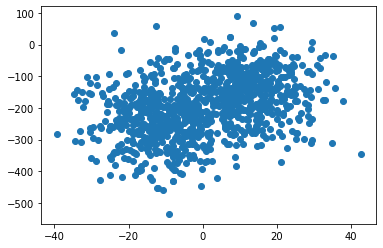


 value of k is 
 10
mu = 6.962343549594323, lambda = 26.019251894160867, epsilon = 0.025791896507143974, delta = 0.025791896507143974
 Iter | Data 	 | Smooth 	 | Obj 	
'
' Adjusted_Rand_Index '
' 0.988024012072048

 col_0    0    1
row_0          
0        1  498
1      499    2


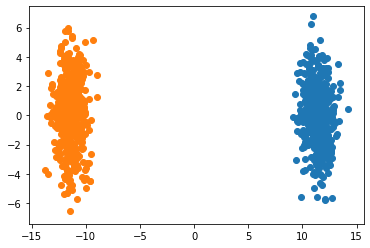

In [2]:
# define dataset
D, labels_true = make_classification(n_samples=1000, n_features=400, n_informative=250, n_classes=2,
                                     n_redundant=100, class_sep=12.0, n_clusters_per_class=1, random_state=1)

plt.scatter(D[:, 0], D[:, 1])
plt.show()

#PCA Starts
D = StandardScaler().fit_transform(D)
#plt.scatter(D[:, 0], D[:, 1])
#plt.show()

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(D)
X = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])

X = X.to_numpy()
#plt.scatter(X[:, 0], X[:, 1])
#plt.show()
#PCA Ends


model = RccCluster(clustering_threshold=100)
model.fit(X)

labels_pred = model.labels_
#print("True Label:", labels_true, "Lable pred:", labels_pred, pred_y, sep='\n\n')

ari = metrics.adjusted_rand_score(labels_true, labels_pred)
print("'\n' Adjusted_Rand_Index '\n'", ari)

#print("'\n' Unique no. of labels '\n'", unique(labels_pred))

print('\n', pd.crosstab(labels_true,labels_pred))

# retrieve unique clusters
clusters = unique(labels_pred)
# create scatter plot for samples from each cluster
for cluster in clusters:
	# get row indexes for samples with this cluster
	row_ix = where(labels_pred == cluster)
	# create scatter of these samples
	plt.scatter(X[row_ix, 0], X[row_ix, 1])
# show the plot
#plt.scatter(model.cluster_centers_[:, 0], model.cluster_centers_[:, 1], s=300, c='yellow')
plt.show()
